In [1]:
import sys
import pandas as pd
import numpy as np


# add path to load on University computer
sys.path.append('/space/ge45leb/Programs/python_packages/')

# functions needed for feature engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# functions needed for model
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def transform_side( cabin_nb ):
    """ Asign numeric values for the cabin side. """
    side = cabin_nb.split('/')[2]
    
    if side == 'P':
        side = 1
    
    elif side == 'S':
        side = -1
    
    else:
        side = 0
        
    return side

## Feature Engineering

In [ ]:
data = pd.read_csv('data/train.csv')


# Split data from labels
y = data['Transported']
X = data.drop(['Transported'], axis=1)

In [ ]:
X.head()

In [16]:
#X['CryoSleep'].value_counts()
#X['HomePlanet'].value_counts()
X['VIP'].value_counts()

0    8494
1     199
Name: VIP, dtype: int64

In [4]:


# I drop the name because most of them appear once (why are there some which appear more often?)
# If no grouping after name is done it should be random. For first try this is good enough.

X = X.drop(['Name'], axis = 1)
#

# Impute nans with most common value in the column

X['CryoSleep'] = (X['CryoSleep'].fillna(False)).astype(int)
X['VIP'] = (X['VIP'].fillna(False)).astype(int)
X['HomePlanet'] = X['HomePlanet'].fillna('Earth')
X['PassengerId'] = X['PassengerId'].map(lambda ID: int(ID.split('_')[0]))


# One-hot encode 3 origin planets 
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X[['HomePlanet', 'Destination']]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X.index

# Replace original columns with one-hot encoded data
num_X = X.drop(['HomePlanet', 'Destination'], axis=1)
X = pd.concat([num_X, OH_cols_train], axis=1)


# Split Cabin information into Floor|Seat|Side
X['Cabin'] = X['Cabin'].fillna('U/-1/U')
X['Floor'] = X['Cabin'].apply(lambda cabin_nb: cabin_nb.split('/')[0])
X['Seat']  = X['Cabin'].apply(lambda cabin_nb: int(cabin_nb.split('/')[1]))
X['Side']  = X['Cabin'].apply(transform_side)

X = X.drop(['Cabin'], axis=1)


# Normalize numeric data
Normalize_col = ['PassengerId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Seat']
X[Normalize_col] = X[Normalize_col] / X[Normalize_col].max()



# Apply ordinal encoder to Floor data (is sensible becasue of the hierachical structure)
ordinal_encoder = OrdinalEncoder()
X['Floor'] = ordinal_encoder.fit_transform(X[['Floor']])

# Fill additional expanses with most common value
services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
X[services] = X[services].fillna(0)
X = X.fillna(0)

In [7]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Build Model 

In [10]:
# Play around with various model types, activation functions etc. 

model = keras.Sequential([
    
    layers.Dense(19, activation='relu', input_shape=[19,]),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    #layers.Dense(19, activation='relu', input_shape=[19,]),
    #layers.Dropout(0.3),
    #layers.Dense(12, activation='relu', input_shape=[19,]),
    #layers.Dropout(0.3),
    layers.Dense(10, activation='relu', input_shape=[19,]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(5, activation='relu', input_shape=[19,]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid', input_shape=[19,]),

])

#

2024-02-20 19:57:46.700696: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Training

In [11]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks


early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=40, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(X_train, y_train, validation_data=[X_test, y_test],
                batch_size=310,
                epochs=2000,
                #callbacks=[early_stopping],
                verbose=0    
                   )

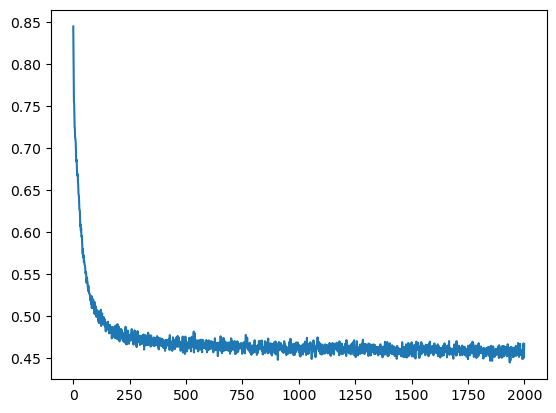

In [12]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

print(X_train.shape)
X_test.shape

In [26]:
from sklearn.metrics import balanced_accuracy_score

preds = (model.predict(X_test) > 0.5).astype('int32')
bacc_nn = balanced_accuracy_score(y_test, preds)

print( f" The score on the test set is: {bacc_nn}")

90/90 [==============================] - 0s 444us/step
 The score on the test set is: 0.7821021733214105


## Make prediction for validation set ( submitted to Kaggle competition)

In [17]:
# Load validation set
X_valid = pd.read_csv('data/test.csv')

# Perform same transformation as on the training set

X_valid = X_valid.drop(['Name'], axis = 1)
X_valid['CryoSleep'] = (X_valid['CryoSleep'].fillna(False)).astype(int)
X_valid['VIP'] = (X_valid['VIP'].fillna(False)).astype(int)
X_valid['HomePlanet'] = X_valid['HomePlanet'].fillna('Earth')
X_valid['PassengerId'] = X_valid['PassengerId'].map(lambda ID: int(ID.split('_')[0]))

# one-hot encoding

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_valid[['HomePlanet', 'Destination']]))
OH_cols_train.index = X_valid.index


num_X_valid = X_valid.drop(['HomePlanet', 'Destination'], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_train], axis=1)

# transform cabin data 

X_valid['Cabin'] = X_valid['Cabin'].fillna('U/-1/U')
X_valid['Floor'] = X_valid['Cabin'].apply(lambda cabin_nb: cabin_nb.split('/')[0])
X_valid['Seat']  = X_valid['Cabin'].apply(lambda cabin_nb: int(cabin_nb.split('/')[1]))
X_valid['Side']  = X_valid['Cabin'].apply(transform_side)
X_valid = X_valid.drop(['Cabin'], axis=1)

Normalize_col = ['PassengerId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Seat']
X_valid[Normalize_col] = X_valid[Normalize_col] / X_valid[Normalize_col].max()


ordinal_encoder = OrdinalEncoder()
X_valid['Floor'] = ordinal_encoder.fit_transform(X_valid[['Floor']])

services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
X_valid[services] = X_valid[services].fillna(0)
X_valid = X_valid.fillna(0)

In [30]:
# make prediction based on trained model

preds = (model.predict(X_valid) > 0.5).astype(int)

# Sample submission (to get right format)
sub=pd.read_csv('data/sample_submission.csv')
sub.head()

134/134 [==============================] - 0s 446us/step


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [31]:
# Sample submission (to get right format)
sub=pd.read_csv('data/sample_submission.csv')

# Add predictions
sub['Transported'] = preds

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

# Output to csv
sub.to_csv('submission.csv', index=False)

In [32]:
preds

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])